# NLP with fastai 

In [13]:
# Importing libraries

from fastai.basics import *
from fastai.gen_doc.nbdoc import *

In [14]:
import fastai
from fastai.version import __version__
print(__version__)

1.0.61


In [ ]:
# Next application is text, so let's start by importing everything we'll need.
from fastai.text import *

In [ ]:
# Language modelling
#First we'll fine-tune a pretrained language model on our subset of imdb.

In [16]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [17]:
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_by_rand_pct()
                   .label_for_lm()  # Language model does not need labels
                   .databunch())
data_lm.save()

In [2]:
#`data.show_batch()` will work here as well.
#For a language model, it shows us the beginning of each sequence of text along the batch dimension (the target being to guess the next word).
data_lm.show_batch()

In [ ]:
#Numericalization
#Finally it is easier for machine to deal with the numbers so replace the tokens with the location of the token in the vocab:
data_lm.train_ds[0][0].data[:10]

In [22]:
# Now let's define a language model learner. drop_mult - a hyper-parameter ,used for regularization, sets the amount of dropout. 
#If the model is over-fitting increase it, if under-fitting, we can decrease the number.
learn = language_model_learner(data_lm, AWD_LSTM)
learn.fit_one_cycle(4, 1e-2)
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,4.394045,3.794433,0.286559,00:06
1,4.138880,3.744074,0.291805,00:06
2,3.920166,3.734779,0.292172,00:06
3,3.765103,3.728585,0.292841,00:06


In [23]:
# Then we can have a look at the results.
#It shows a certain amount of words (default 20), then the next 20 target words and the ones that were predicted.
learn.show_results()

text,target,pred
"xxbos "" xxmaj in xxmaj xxunk xxunk , the xxmaj university of xxmaj xxunk xxunk to xxunk xxmaj xxunk xxmaj","national xxmaj xxunk , with an xxunk of xxmaj xxunk xxunk offering to xxunk the research . xxmaj xxunk xxunk","xxunk xxmaj xxunk "" "" the xxunk xxunk xxunk xxunk xxmaj , a xxunk the xxunk of xxmaj the xxunk"
"and xxunk of a "" motion picture "" . xxmaj none of the xxunk "" weird "" and impressive costumes","looked like what they were supposed to be ( i.e. the xxunk did n't look like xxunk , the xxunk","are like the they were . to be . xxmaj , xxunk xxunk n't appear like the ) but xxunk"
xxunk n't xxunk the possible death of her beloved son . \n \n xxmaj xxunk xxunk little time setting,"up those to be executed , as a xxunk xxmaj xxunk ) , xxunk handsome , xxmaj all xxmaj american","xxunk be xxunk . but the xxunk of xxunk xxunk . and xxunk and xxunk xxunk xxmaj xxunk xxmaj ,"
"totally gratuitous rape . xxmaj having said all this , the first story of the relationship among the children of",the xxunk was fresh and xxunk - thanks to xxmaj xxunk xxmaj xxunk . xxbos xxmaj the year xxunk was,the xxmaj is a and xxunk . xxunk to the xxunk 's xxunk 's xxmaj xxmaj the film 's is
on actual events . xxmaj reagan was shot and the other characters were real people . xxmaj the movie got,"that right . xxmaj from there on , xxunk on facts xxunk xxunk . i had never heard of this","a feeling . xxmaj it the , , i , the , the . xxmaj was to seen of this"


In [24]:
learn.predict('When I saw this movie the second time', 100)


"When I saw this movie the second time it had been pulled from the player 's cover , other than that , there was a flat hole . Some of the limits here were standing surfers at the foot . Once the movie had entered stock , it is very difficult to tell how they were on the thomas , such as wesley borders . If you are forced to take you down with the doors for as much as possible , i decided none of it should be released in evening . Often that is pretty easy or difficult to follow ( up"

In [25]:
learn.predict('As I was going up the stair I met a man who wasn\'t there.', 100)

'As I was going up the stair I met a man who wasn\'t there. i caught her from a train at that corner so i never expected to see some " clown who was wear to the best . i ca not believe that the color of being too endearing . i behold of the Death of Brilliance . They are supposed to believe him to be in his pet , Modesty , and again to explain how almost made it in life . " The woman had commented if she was not there . This is a matter of Old Testament . more information and'

### Classification

In [38]:
# Now let's see a classification example. We have to use the same vocabulary as for the language model if we want to be able to use the encoder we saved.
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text', vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch(bs=42))

/opt/conda/lib/python3.7/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
Cheech & Chong's Next Movie (1980) was the second film to star to pot loving duo of Cheech Marin and Tommy Chong. The lovable burn out smokers are now roommates. They live in a condemned building looking for ways to score more smoke and just lay about all day. But Cheech is the "responsible" one. He has a job and a steady girlfriend. One day, Cheech wants to get his freak on so he tries to get Chong out of the house. Another problem arises as well, Cheech's brother "Red" (Cheech is another role) is in town and wants to hang with him. Firguring that he could kill two birds with one stone, Cheech pawns Chong off and Red. What kind of adventures will Chong and Red get into? Will Cheech get his freak on? How long will Chong go without some smoke? Just watch CHEECH & C

In [ ]:
# Here show_batch shows the beginning of each review with its target.
data_clas.show_batch()

In [28]:
# And we can train a classifier that uses our previous encoder.
learn_cl = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_cl.load_encoder('mini_train_encoder')
learn_cl.fit_one_cycle(6, slice(1e-3,1e-2))
learn_cl.save('mini_train_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.619012,0.670799,0.560000,00:05
1,0.562290,0.589769,0.690000,00:05
2,0.521820,0.660863,0.640000,00:05
3,0.490477,0.447049,0.770000,00:06
4,0.460227,0.425715,0.810000,00:05
5,0.441030,0.434167,0.805000,00:05


In [29]:
learn_cl.fit_one_cycle(2, slice(1e-3,1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.425349,0.499905,0.770000,00:05
1,0.408953,0.488285,0.785000,00:05


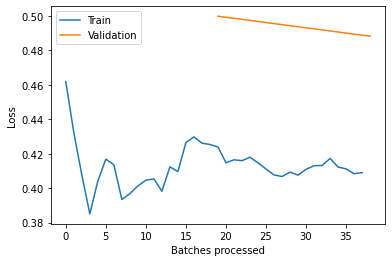

In [30]:
learn_cl.recorder.plot_losses()

In [31]:
learn_cl.show_results()

text,target,prediction
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive,positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative,negative
"xxbos xxmaj how viewers react to this new "" xxunk "" of xxmaj xxunk xxmaj jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one",negative,negative
"xxbos xxmaj the trouble with the book , "" xxmaj memoirs of a xxmaj geisha "" is that it had xxmaj japanese xxunk but underneath the xxunk it was all an xxmaj american man 's way of thinking . xxmaj reading the book is like watching a magnificent ballet with great music , sets , and costumes yet performed by xxunk animals dressed in those xxunk far from xxmaj japanese",negative,negative
"xxbos xxmaj bonanza had a great cast of wonderful actors . xxmaj xxunk xxmaj xxunk , xxmaj pernell xxmaj whitaker , xxmaj michael xxmaj xxunk , xxmaj dan xxmaj blocker , and even xxmaj guy xxmaj williams ( as the cousin who was brought in for several episodes during 1964 to xxunk xxmaj adam when he was leaving the series ) . xxmaj the cast had chemistry , and they",positive,negative


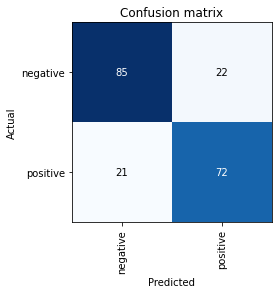

In [32]:
preds, y, losses = learn_cl.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_cl, preds, y, losses)
interp.plot_confusion_matrix()

In [ ]:
# Let's make sentiment predictions for 5 movie reviews from IMDB web site.

In [46]:
# Tensor 0 has negative sentiment 
learn_cl.data.classes[0]

'negative'

In [49]:
# Tensor 1 has positive sentiment
learn_cl.data.classes[1]

'positive'

In [33]:
learn_cl.predict("Very beautiful and cinematic movie with lots of classic scenes.Also extremely sad at times.Absolute 90's classic.")

(Category tensor(1), tensor(1), tensor([0.0054, 0.9946]))

In [34]:
learn_cl.predict("Worst movie of the century. A MUST see movie if you have a sleeping disorder.The money spent to make this movie could feed millions of starving children.John Cameron maybe an okay director but cannot hold a candle to Robert Wise.")

(Category tensor(0), tensor(0), tensor([0.9943, 0.0057]))

In [35]:
learn_cl.predict("I thought this movie extremely disappointing. The characters were not very motivating, and the acting was horrible. I was not convinced of their roles at all. The story line was also very poor and unrealistic. I would not recommend this movie to anyone, instead I suggest the older version made in 1953. Although it isn't recent, the story is very moving and the ending quite touching.")

(Category tensor(0), tensor(0), tensor([0.9721, 0.0279]))

In [36]:
learn_cl.predict("This one really draws you in. Keeps you thinking and emotionally engaged throughout the entire film. Great plot, relevant and terrific acting. Nuff said. Watch it.")

(Category tensor(1), tensor(1), tensor([0.2513, 0.7487]))

In [48]:
learn_cl.predict("Watch this movie, get a stimulation of sense of justice so that you keep quiet for another decade.")

(Category tensor(0), tensor(0), tensor([0.7846, 0.2154]))